<a href="https://colab.research.google.com/github/felixlys/forecast_with_StochProcess/blob/main/Forecasting_ARIMA_BBCA_JK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Peramalan Harga Saham BBCA.JK dengan Menggunakan ARIMA

Pada penelitian ini, dilakukan peramalan harga saham BBCA.JK periode 12 Juni 2024 -1 November 2024(data 100 hari) dengan menggunakan data 1 Juli 2019-1 November 2024( data 1953 Hari). Dengan tahapan sebagai berikut :


# 1.   Pengambilan Data Saham
Adapun sumber data harga saham berasal dari Yahoo Finance. Pada penelitian ini, data harga yang digunakan adalah data Close Price BBCA.JK

In [10]:
install.packages("quantmod")
library(quantmod)
BBCA_data<-getSymbols(Symbols="BBCA.JK",src="yahoo",from=Sys.Date()-1953,to=Sys.Date(),auto.assign=FALSE)
head(BBCA_data)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



           BBCA.JK.Open BBCA.JK.High BBCA.JK.Low BBCA.JK.Close BBCA.JK.Volume
2019-07-02         5990         6000        5950          6000       48563500
2019-07-03         5950         6000        5940          6000       43640000
2019-07-04         6000         6010        5965          5990       28224500
2019-07-05         6020         6020        5970          5970       32722500
2019-07-08         5935         5960        5865          5880       38361000
2019-07-09         5870         6000        5870          6000       47740500
           BBCA.JK.Adjusted
2019-07-02         5390.973
2019-07-03         5390.973
2019-07-04         5381.989
2019-07-05         5364.019
2019-07-08         5283.154
2019-07-09         5390.973

           BBCA.JK.Close
2019-07-02          6000
2019-07-03          6000
2019-07-04          5990
2019-07-05          5970
2019-07-08          5880
2019-07-09          6000

           BBCA.JK.Close
2024-10-28         10600
2024-10-29         10500
2024-10-30         10350
2024-10-31         10250
2024-11-01         10425
2024-11-04         10375

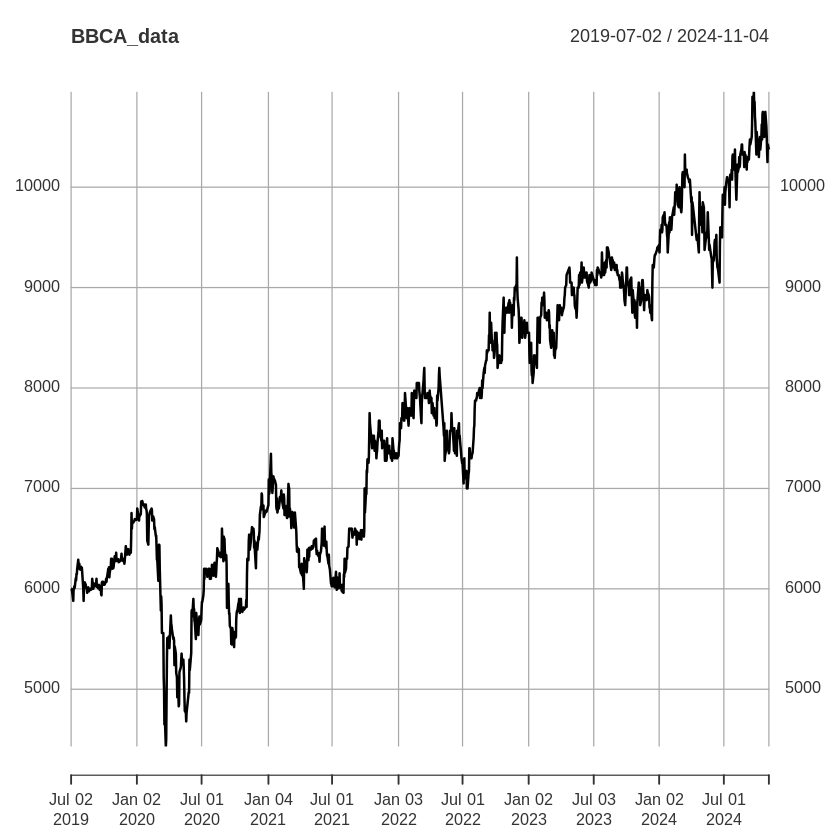

In [11]:
BBCA_data<-Cl(BBCA_data)
head(BBCA_data)
tail(BBCA_data)
plot(BBCA_data)

Tampak bahwa data Close Price BBCA memiliki tren naik.

# 2.   Dapatkan Log Price
Berdasarkan asumsi ekonomi, ekspektasi pertumbuhan harga saham merupakan *Continously Compounded Interest Rate*, yakni bunga yang dibayarkan secara kontinu sehingga model matematika harga saham ke-t adalah
$$S_{t}=S_{0}e^{\mu t},t\geq 0$$
dengan $\mu$ merupakan rate of return kontinu. Sehingga untuk mendapatkan rate of return nya disetiap hari-hari trading digunakan formula
$$\mu_{t}=\ln\bigg(\frac{S_{t}}{S_{t-1}}\bigg)=\ln(S_{t})-\ln(S_{t-1})$$.

Untuk itu pada tahap kedua, akan dicari log price BBCA_JK terlebih dahulu, kemudian dilakukan pengecekan kurva ACF dan PACF, namun jika terbukti log price tidak stasioner, maka dilakukan differencing untuk mendapatkan  $\mu_{t}$.



           BBCA.JK.Close
2019-07-02      8.699515
2019-07-03      8.699515
2019-07-04      8.697847
2019-07-05      8.694502
2019-07-08      8.679312
2019-07-09      8.699515
2019-07-10      8.699515
2019-07-11      8.703673
2019-07-12      8.701180
2019-07-15      8.716863

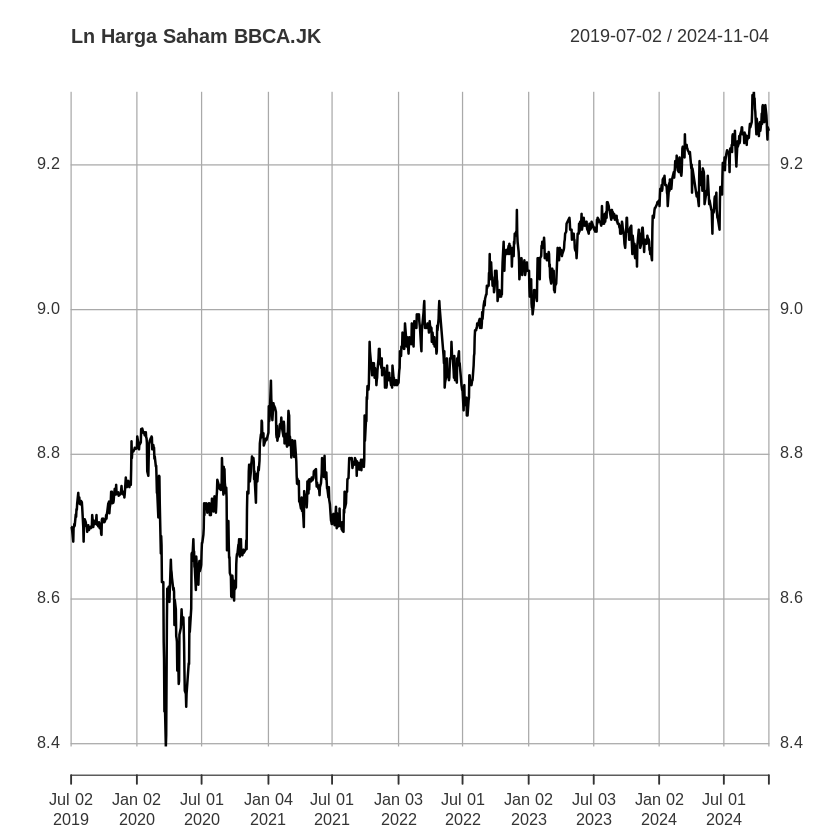

In [12]:
BBCA_log<-log(BBCA_data)
head(BBCA_log,n=10)
plot(BBCA_log,main="Ln Harga Saham BBCA.JK")

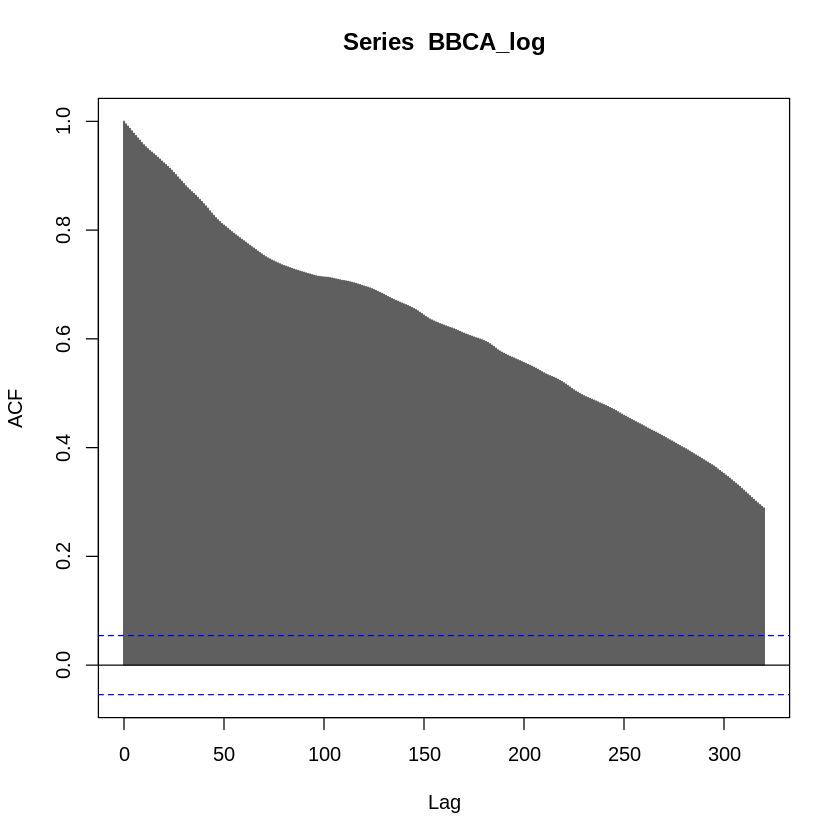

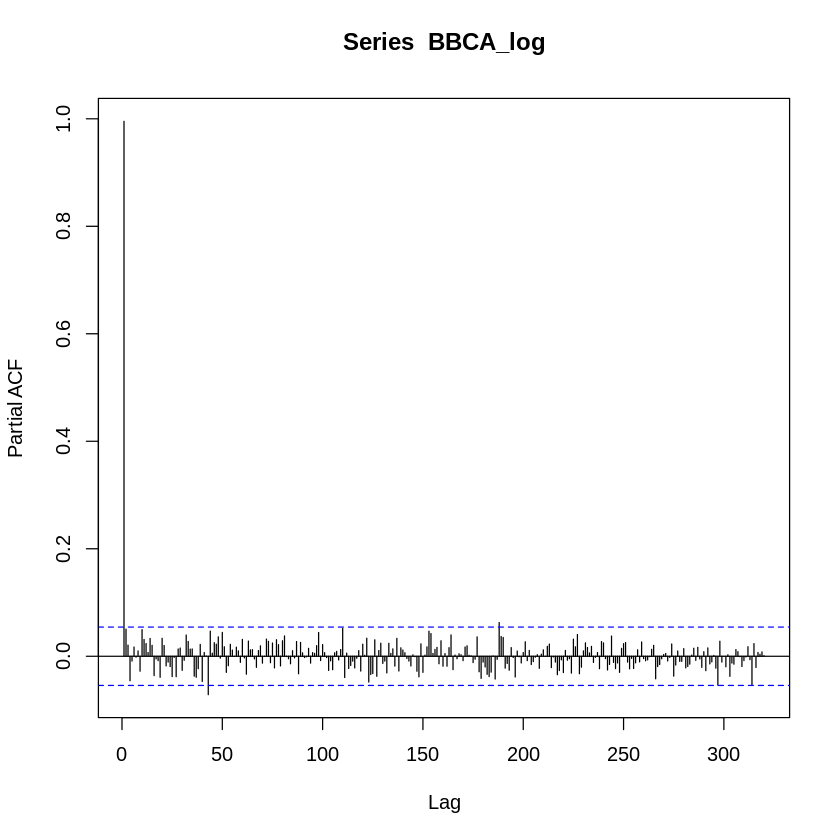

In [13]:
acf_log<-acf(BBCA_log,lag.max=320)
pacf_log<-pacf(BBCA_log,lag.max=320)

Hasil Analisis
1. ACF : Menunjukkan korelasi antara nilai data waktu tertentu pada beberapa waktu sebelumnya (lag), dan parameter model. Pada kurva ACF ini tampak menurun, namun terdapat batang/spike yang berada di atas garis batas signifikasi. Hal ini menunjukkan data nya tidak stasioner.
2. PACF : Mengidetifikasi lag-lag signifikan dalam data, dan digunakan utk menentukan parameter model. Pada kurva PACF ditunjukkan tidak ada cutoff yang jelas (maksudnya tidak ada lag yg nilai PACF nya menurun setelah melewati nilai tertentu).

Selanjutnya, karena model ARIMA membutuhkan data yang stasioner, maka dilakukan tahap differencing


# 3.  Differencing Data
Salah satu cara yang dapat digunakan untuk membuat data ln harga saham menjadi stasioner adalah dengan melakukan differencing. Adapun formula yang digunakan adalah sebagai berikut

$$\nabla\ln(S_{t})=\ln(S_{t})-\ln(S_{t-1}).$$
Berdasarkan teori logaritma, maka formula differencing ini sama dengan ln return.

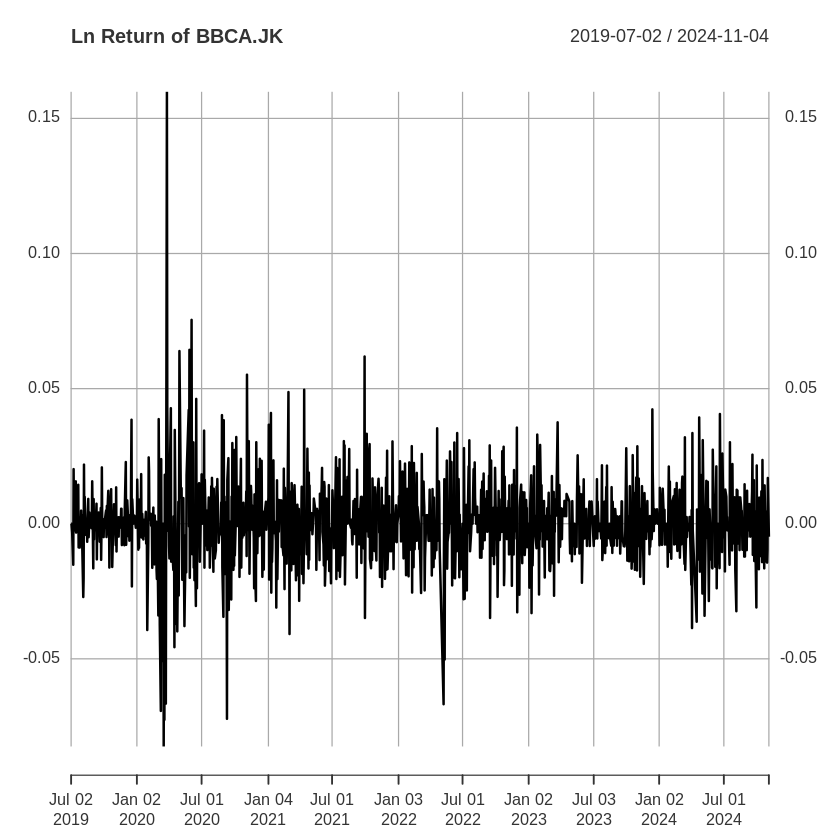

In [14]:
BBCA_diff<-diff(BBCA_log,lag=1)
BBCA_diff<-na.locf(BBCA_diff,na.rm=TRUE,fromLast=TRUE)
plot(BBCA_diff,main="Ln Return of BBCA.JK ")

# 4. Uji Kestasioneran
Untuk menguji kestasioneran, digunakan Uji Augmented Dickey-Fuller Test (ADF) untuk data BBCA_log dan BBCA_diff.

In [15]:
install.packages("tseries")
library(tseries)
#Untuk Ln Harga Saham
adf<-adf.test(BBCA_log,alternative=c("stationary","explosive"),k=0)
adf
#Untuk Ln Return
adf1<-adf.test(BBCA_diff,alternative=c("stationary","explosive"),k=0)
adf1

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in adf.test(BBCA_log, alternative = c("stationary", "explosive"), :
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  BBCA_log
Dickey-Fuller = -4.1334, Lag order = 0, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(BBCA_diff, alternative = c("stationary", "explosive"), :
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  BBCA_diff
Dickey-Fuller = -39.2, Lag order = 0, p-value = 0.01
alternative hypothesis: stationary


Perhatikan bahwa untuk Augmented Dickey Fuller Test memiliki hipotesis sebagai berikut : \\
$$H_{0}:\text{Data Tidak Stasioner}$$
$$H_{1}:\text{Data Stasioner}$$
dengan daerah penolakan
$$pval< 0.05\hspace{1cm}H_{0}\hspace{0.5cm}\text{ditolak},$$
$$pval> 0.05\hspace{1cm}H_{1}\hspace{0.5cm}\text{diterima}.$$
Karena pval untuk data ln return adalah pval=0.01< 0.05, maka terbukti data ln return sudah stasioner, sehingga memenuhi kriteria untuk model ARIMA

# 5. ACF dan PACF untuk mendapatkan Parameter

Pada tahap ini, akan dilakukan plot kurva ACF dan PACF dari data differencing

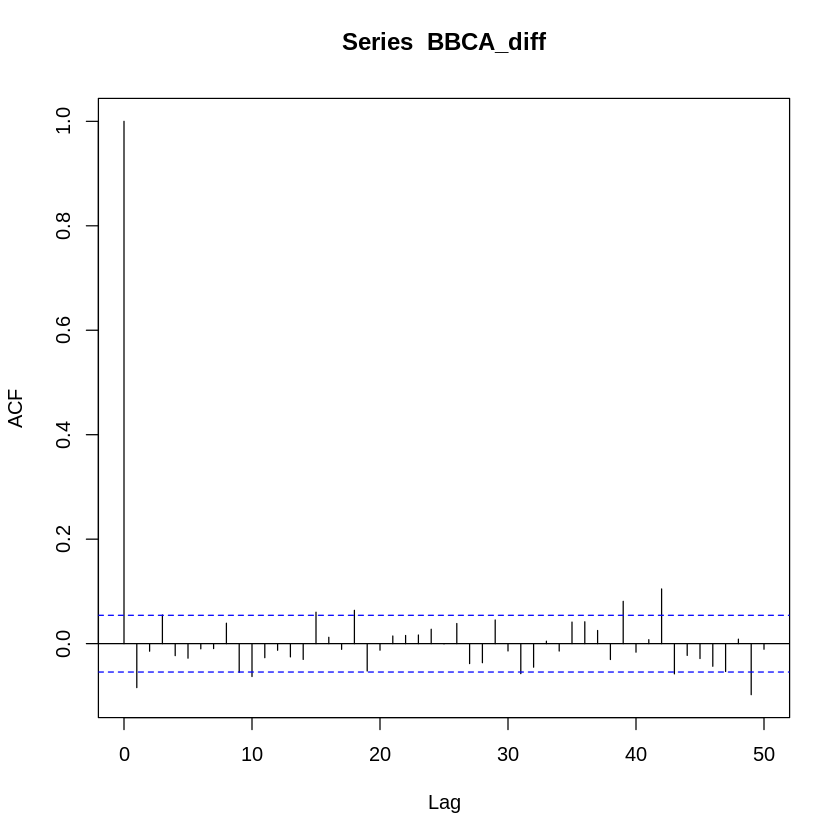

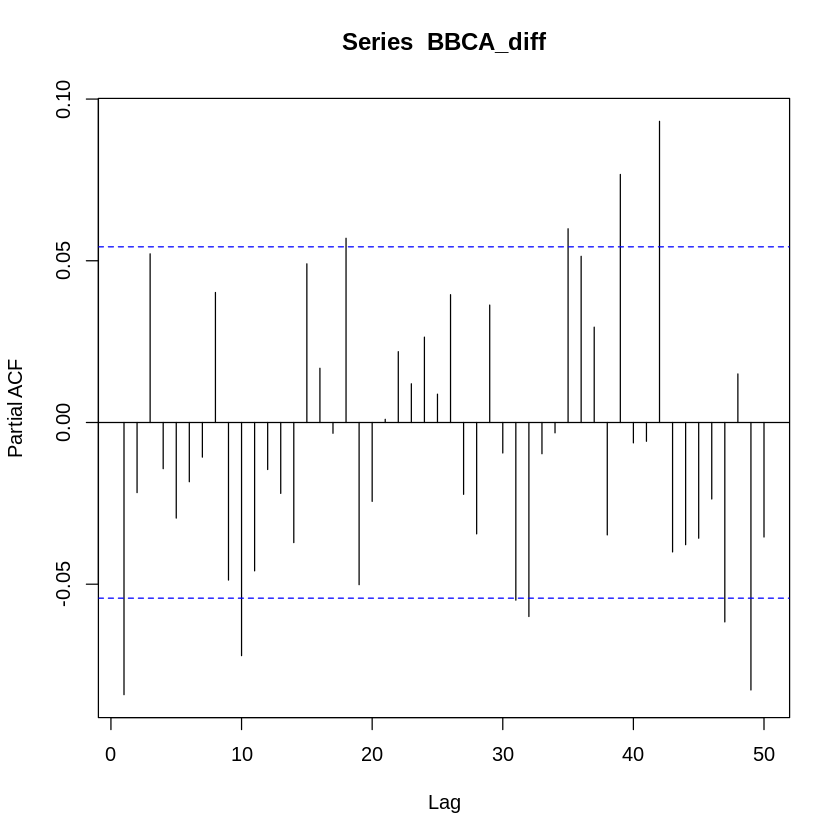

In [16]:
acf_log<-acf(BBCA_diff,lag.max=50)
pacf_log<-pacf(BBCA_diff,lag.max=50)

Indikator analisis :
Setelah data stasioner (telah melalui differencing sesuai nilai d), Anda dapat menggunakan plot ACF dan PACF untuk menentukan nilai p dan q.
1. Menentukan p (Order AR): Perhatikan PACF dari data yang telah di-differencing.
Jika PACF terpotong pada lag tertentu (cut-off), maka itu menunjukkan nilai p.
Misalnya, jika PACF terpotong pada lag 1 setelah differencing, maka kemungkinan besar p = 1.
2. Menentukan q (Order MA): Perhatikan ACF dari data yang telah di-differencing.
Jika ACF terpotong pada lag tertentu, maka itu menunjukkan nilai q.
Misalnya, jika ACF terpotong pada lag 2 setelah differencing, maka kemungkinan besar q = 2.

Hasil :
Pada kurva ACF dan PACF menujukkan:
1. Pada kurva PACF terjadi cutoff pada lag 1, sehingga sementara kita menduga AR(1) merupakan model yang cocok
2. Pada kurva ACF terjadi cutoff pd lag 1(lag terakhir yang nilai ACF nya menembus batas signifikasi) sehingga kita boleh menduga MA(1).
3. Karena dilakukan differencing satu kali maka kita boleh menduga ARIMA(p,d,q)=ARIMA(1,1,1).

# 5. Menggunakan Fungsi AutoARIMA:

Menggunakan function AutoARIMA di R kita juga bisa menebak model ARIMA manakah yang cocok dengan data terkait. Pada penelitian ini, kita akan mengkomparasikan hasil AutoARIMA dan tebakan kita ARIMA(1,1,1) dan meninjau performanya berdasarkan nilai MAPE.\\

Sebelum itu, kita harus melakukan pembagian data yang akan dijadikan training dan testing. Adapun data yang akan digunakan sebagai data training adalh data saham 1270 hari, sisanya digunakan untuk dibandingkan dengan hasil forecast model ARIMA yang kita hasilkan

In [18]:
install.packages("caTools")
library(caTools)
train_data<-BBCA_diff[1:1270]

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’




In [19]:
install.packages("forecast")
library(forecast)
set.seed(123)
arima_model <- auto.arima(train_data, stationary = TRUE, ic = c("aicc", "aic", "bic"),
                          trace = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’





 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -6957.02
 ARIMA(1,0,0) with non-zero mean : -6962.02
 ARIMA(0,0,1) with non-zero mean : -6963.29
 ARIMA(0,0,0) with zero mean     : -6957.876
 ARIMA(1,0,1) with non-zero mean : -6960.319
 ARIMA(0,0,2) with non-zero mean : -6961.381
 ARIMA(1,0,2) with non-zero mean : -6959.865
 ARIMA(0,0,1) with zero mean     : -6963.938
 ARIMA(1,0,1) with zero mean     : -6960.96
 ARIMA(0,0,2) with zero mean     : -6962.012
 ARIMA(1,0,0) with zero mean     : -6962.689
 ARIMA(1,0,2) with zero mean     : -6960.47

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,1) with zero mean     : -6963.931

 Best model: ARIMA(0,0,1) with zero mean     



In [20]:
summary(arima_model)

Series: train_data 
ARIMA(0,0,1) with zero mean 

Coefficients:
          ma1
      -0.0805
s.e.   0.0281

sigma^2 = 0.0002427:  log likelihood = 3483.97
AIC=-6963.94   AICc=-6963.93   BIC=-6953.65

Training set error measures:
                       ME       RMSE        MAE MPE MAPE      MASE
Training set 0.0005093993 0.01557287 0.01053937 NaN  Inf 0.6295573
                      ACF1
Training set -0.0004657387

Didapat model ARIMA(0,0,1) sebagai berikut :
$$BBCA_{t}=\mu-0.0805U_{t-1}+U_{t}$$
dengan $0.0805U_{t-1},U_{t}$ merupakan suku Moving Average (MA) dan $U_{t},U_{t-1}$ bernilai random. Selanjutnya, dilakukan tes residual yang bertujuan untuk memastikan error nya terdistribusi normal dan disimpulkan model itu baik. Pada test Ljung-Box diharapkan kita mendapatkan pval>0.05 yang artinya error/residuals pada model ARIMA tidak berkorelasi dgn kata lain independen.


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with zero mean
Q* = 18.86, df = 9, p-value = 0.02641

Model df: 1.   Total lags used: 10



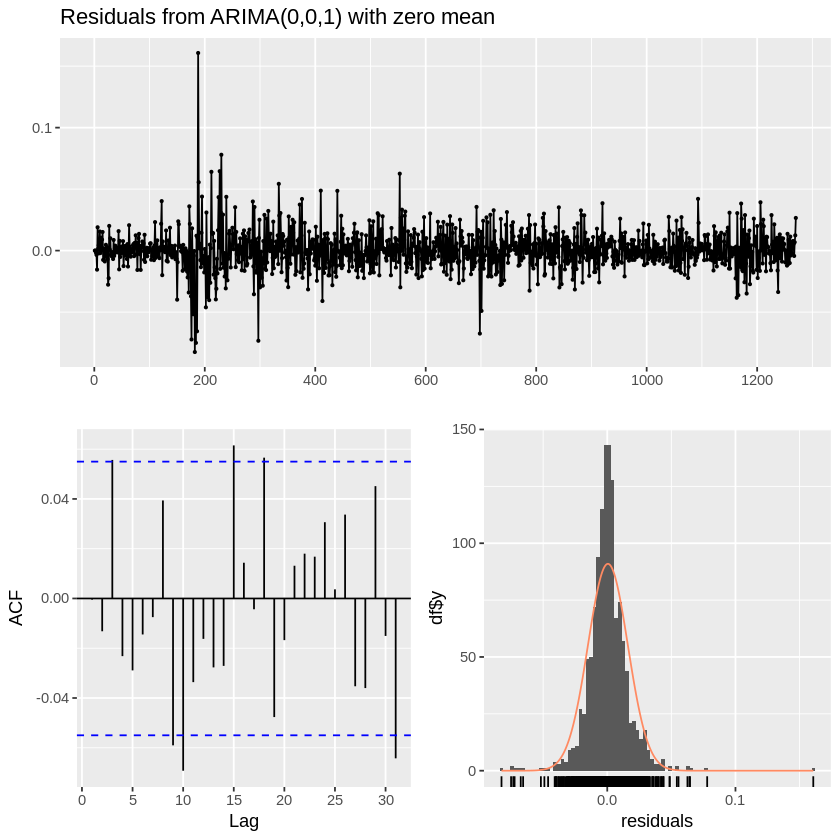

In [23]:
checkresiduals(arima_model)

Perhatikan bahwa pval=0.02641< 0.05, yang artinya residualnya tdk independen, sehingga kita harus mempertimbangkan model lain yakni ARCH atau GARCH.

# 6. Fitting ARIMA model and Forecasting
Kita tahu model yang tepat berdasarkan autoarima adalah ARIMA(0,0,1) dan berdasarkan konsep nya adalah ARIMA(1,1,1) misalkan model tersebut kita namai sebagai arima dan arima1

In [24]:
arima<-arima(train_data,order=c(0,0,1))
arima1<-arima(train_data,order=c(1,1,1))

Selanjutnya, kita lakukan forecast untuk data 100 hari kedepan

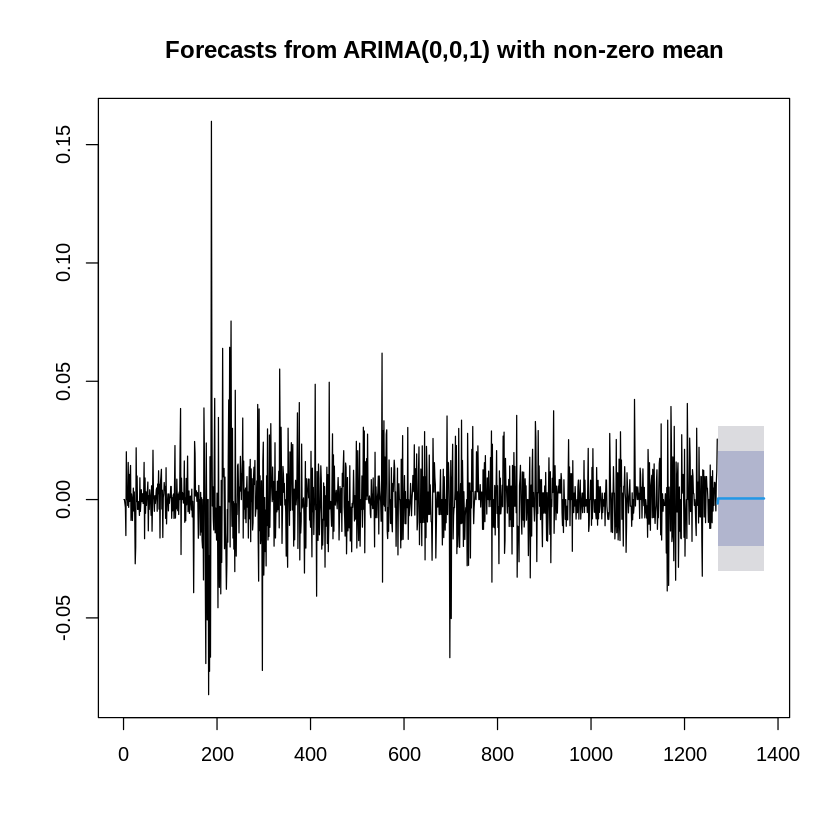

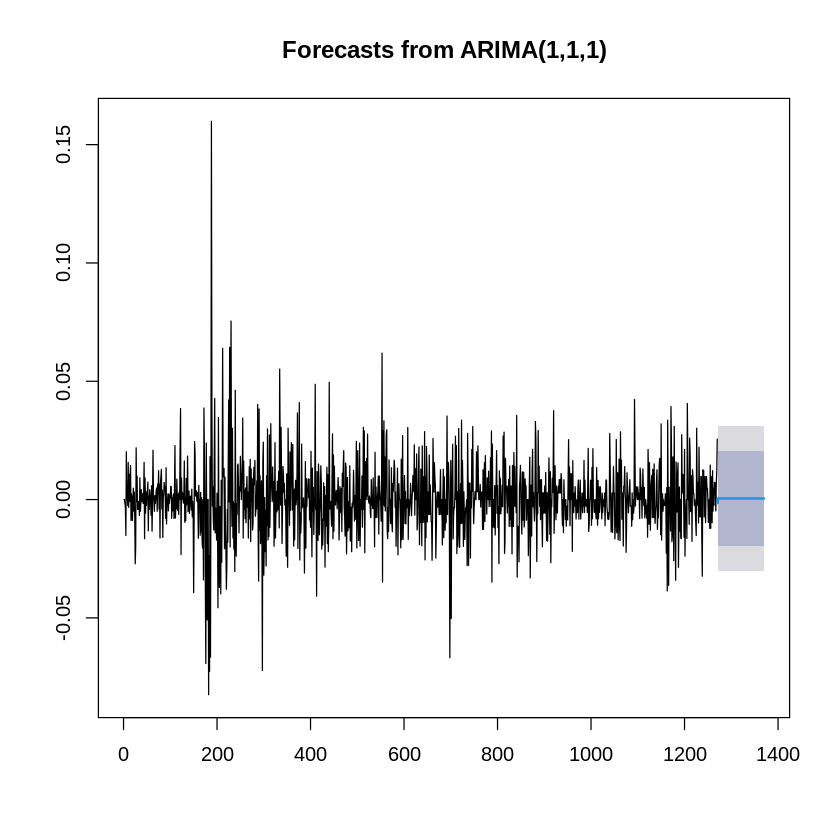

In [27]:
forecast1<-forecast(arima,h=100)
plot(forecast1)
forecast2<-forecast(arima1,h=100)
plot(forecast2)


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 18.867, df = 9, p-value = 0.02635

Model df: 1.   Total lags used: 10



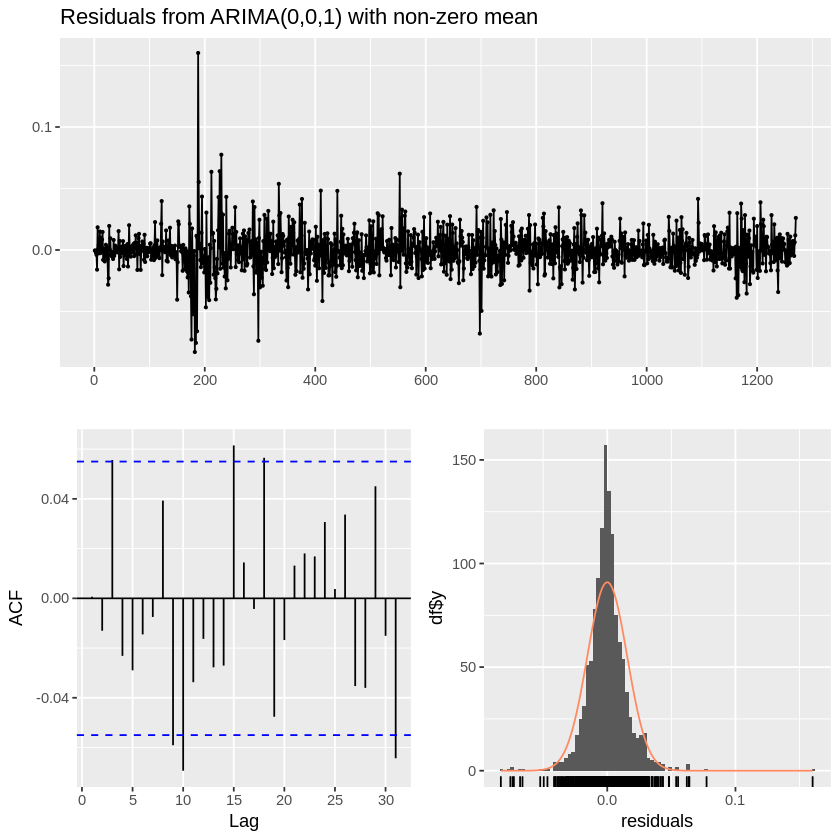


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)
Q* = 19.121, df = 8, p-value = 0.01423

Model df: 2.   Total lags used: 10



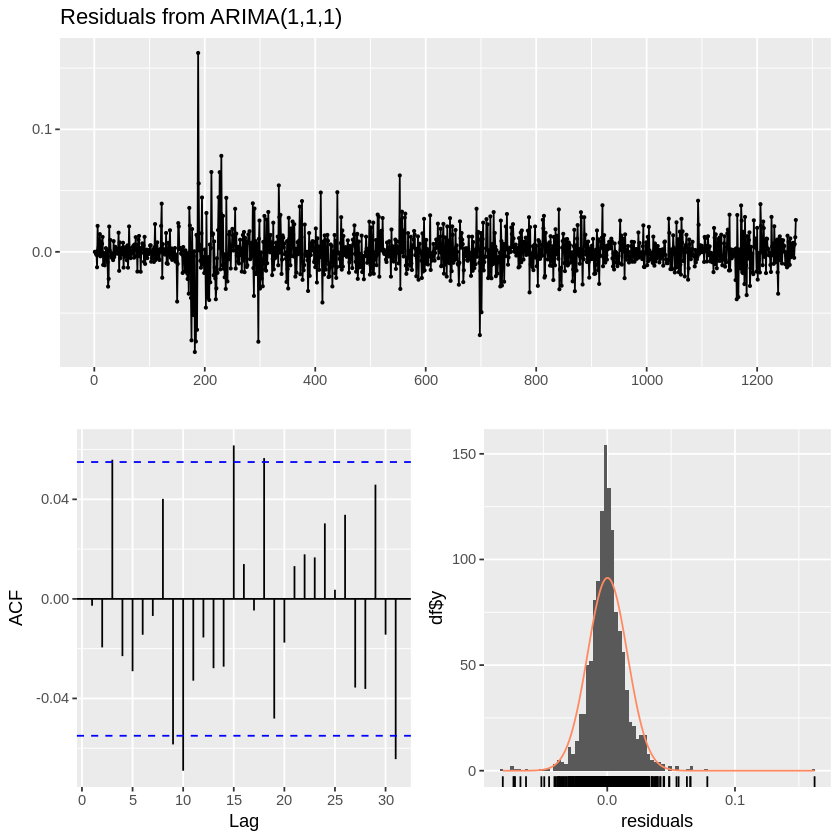

In [28]:
checkresiduals(arima)
checkresiduals(arima1)

Karena pval yang diperoleh adalah pval1=0.02635< 0.05(utk ARIMA(0,0,1))  dan pval=0.01423< 0.05 utk ARIMA(1,1,1) artinya ARIMA perlu untuk dilakukan penggantian dan memungkinkan ke model GARCH. Pada penelitian ini, misalkan kita mengasumsikan ARIMA(0,0,1) dan ARIMA(1,1,1) yang dipilih untuk dilakukan forecast ln harga saham, berikut adalah model ARIMA terkait

In [32]:
arima<-arima(BBCA_log[1:1270],order=c(0,0,1))
summary(arima)
arima1<-arima(BBCA_log[1:1270],order=c(1,1,1))
summary(arima1)


Call:
arima(x = BBCA_log[1:1270], order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.9392     8.9193
s.e.  0.0067     0.0055

sigma^2 estimated as 0.01022:  log likelihood = 1107.44,  aic = -2208.89

Training set error measures:
                      ME     RMSE        MAE         MPE      MAPE     MASE
Training set 6.49464e-05 0.101086 0.08778341 -0.02284806 0.9851401 8.263757
                  ACF1
Training set 0.8842903


Call:
arima(x = BBCA_log[1:1270], order = c(1, 1, 1))

Coefficients:
         ar1      ma1
      0.0348  -0.1147
s.e.  0.2354   0.2335

sigma^2 estimated as 0.0002427:  log likelihood = 3480.74,  aic = -6955.49

Training set error measures:
                       ME       RMSE        MAE         MPE      MAPE      MASE
Training set 0.0005174806 0.01557459 0.01054847 0.005586913 0.1187578 0.9930123
                      ACF1
Training set -0.0008440981

Tampak bahwa MAPE untuk ARIMA(0,0,1) adalah $98.51\%$, dengan kata lain ARIMA(0,0,1) meramalkan data harga saham dengan akurasi yang sangat buruk. Sedangkan untuk ARIMA(1,1,1) memiliki MAPE $11.87\%$, dengan kata lain ARIMA(1,1,1) meramalkan harga saham dengan akurasi yang cukup baik.

# 7. Plot Kurva Forecasting

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



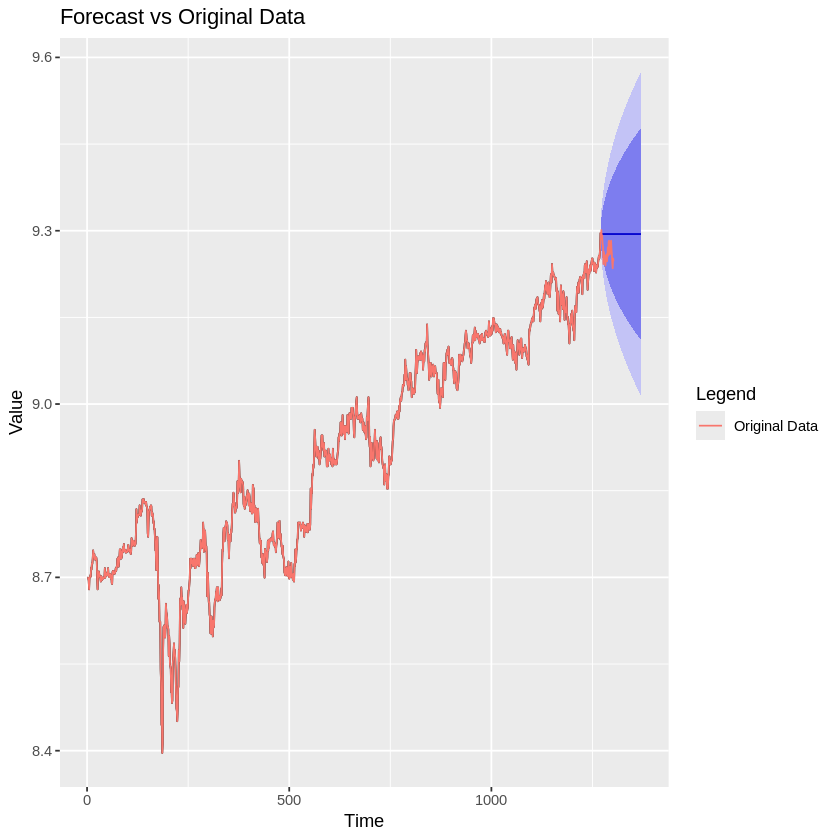

In [35]:
# Pastikan paket yang diperlukan sudah diinstal
install.packages("forecast")
install.packages("ggplot2")

# Load library yang dibutuhkan
library(forecast)
library(ggplot2)

# Melakukan forecasting
forecast_ori <- forecast(arima1, h = 100)

# Data time series asli
a <- ts(BBCA_log)

# Plot forecast dan data asli menggunakan autoplot
autoplot(forecast_ori) +
  autolayer(a, series = "Original Data") +
  labs(title = "Forecast vs Original Data",
       x = "Time",
       y = "Value") +
  guides(colour = guide_legend(title = "Legend"))


In [39]:
#MEAN FORECAST
forecast_values <- exp(forecast_ori$mean)
forecast_df <- data.frame(
  Time = seq_along(forecast_values),  # Indeks waktu dari 1 hingga panjang forecast
  Forecast = forecast_values          # Nilai forecast
)


forecast_df


Time,Forecast
<int>,<ts>
1,10876.49
2,10875.67
3,10875.64
4,10875.64
5,10875.64
6,10875.64
7,10875.64
8,10875.64
9,10875.64


Berikut merupakan hasil forecast minimum harga saham BBCA.JK 100 hari kedepan

In [40]:
#MINIMUM Forecast
forecast_values_min <- exp(forecast_ori$lower)
forecast_df1 <- data.frame(
  Time = seq_along(forecast_values_min),  # Indeks waktu dari 1 hingga panjang forecast
  Forecast = forecast_values_min          # Nilai forecast
)
forecast_df1


Time,Forecast.80.,Forecast.95.
<int>,<dbl>,<dbl>
1,10661.492,10549.406
2,10584.590,10433.667
3,10525.430,10344.627
4,10475.304,10269.378
5,10431.075,10203.139
6,10391.096,10143.393
7,10354.369,10088.614
8,10320.234,10037.794
9,10288.228,9990.224


Perhatikan bahwa 80% dan 95% adalah selang kepercayaan.